<a href="https://colab.research.google.com/github/Sovit1056/Pytorch_practice/blob/main/04_Pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.4 PyTorch Custom Datasets

We've ued some datasets with pytorch before.

BUt now we will use our own data via: custom datasets.

## Domain Libraries: https://pytorch.org/domains/

Depending on what we are working on:
* Vision: https://docs.pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets
* Text :
* Audio
* Recommendation: like in social media plaform
* Different other data
We'll look into the PyTorch domain libraries for existing data loading function and customize data loading function.

**Resources:**
* Book Version: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## What are we going to cover

* Getting a **custom data** with pytorch
* Preaparing and visualizing our data
* **Transforming data** for use with a model
* **Loading custom data** with pre-built function and custom function
* Building computer vision **model**
* Comparing model with and without **Data augmentation**
* **Making prediction** on custom data.

### Things remain to learn

* Code to creat our own **custom data** set.

## 0. Import Libraries and Setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Seetting the device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!nvidia-smi

Tue Jul 22 04:38:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

* Tutors dataset is a subset of the Food101 dataset.

* Food101 starts 101 different class of food and 1000 images per class (750 training, 250 testing).

* Tutors dataset starts with 3 classes of food and only 10% of the images ( i.e 75 training and 25 testing)

  Why this?

  * When starting out ML project, it's important to try things on small scale and then increase the scale when done.
  * It is to speed up our experiment

### Importing Zip file from Github

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnot exist, download and unzip it......
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data: we can also download in local drive from github and upload without coding tooo.
with open (data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip file:

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file...")
    zip_ref.extractall(image_path)



Did not find data/pizza_steak_sushi directory, creating one...
Unzipping the file...


In [4]:
# reset our working directory to /content, where your uploads, mounts, and downloaded files are normally accessible

%cd /content


/content


## 2. Data preparation and Data exploration

In [5]:
import os
def walk_through_dir(dir_path):
  # Walking through dir_path returing its contents.
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [6]:
# Setup train and test paths

train_dir = image_path / "train"  # look how to crete the path as from data_path = Path("data/") and image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

We can directly look from the dataset folder.

But let's try to visualize the image using code.
1. Get all of the image path.
2. Pick a random image path through `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open image with Python's PIL (pillow): https://pypi.org/project/pillow/
5. We'll then show image and print metadata.

| **Function / Setting**                      | **Library / Module**            | **Purpose**                                                       | **Controls**                                                                                                 | **Notes**                                                  |
| ------------------------------------------- | ------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------- |
| `random.seed(seed)`                         | Python built-in `random` module | Sets seed for Python's default pseudo-random number generator.    | Affects `random.random()`, `random.randint()`, `random.shuffle()`, etc.                                      | Does **not** affect NumPy or PyTorch randomness.           |
| `np.random.seed(seed)`                      | NumPy                           | Sets seed for NumPy's PRNG.                                       | Controls NumPy functions like `np.random.rand()`, `np.random.randn()`, etc.                                  | Does **not** affect Python `random` or PyTorch randomness. |
| `torch.manual_seed(seed)`                   | PyTorch                         | Sets seed for PyTorch's CPU and general PRNG.                     | Controls PyTorch functions like `torch.rand()`, `torch.randn()`, weight initialization, data shuffling, etc. | Recommended for all PyTorch workflows.                     |
| `torch.cuda.manual_seed(seed)`              | PyTorch CUDA                    | Sets seed for **CUDA PRNG** on current GPU.                       | Controls PyTorch CUDA random operations.                                                                     | Needed for reproducibility in GPU computations.            |
| `torch.cuda.manual_seed_all(seed)`          | PyTorch CUDA (multi-GPU)        | Sets seed for all GPUs.                                           | Controls CUDA randomness across all GPUs in multi-GPU setups.                                                | Use in multi-GPU training.                                 |
| `torch.backends.cudnn.deterministic = True` | PyTorch cuDNN backend           | Forces deterministic algorithms in cuDNN.                         | Makes convolution and similar operations reproducible.                                                       | May slightly reduce training speed.                        |
| `torch.backends.cudnn.benchmark = False`    | PyTorch cuDNN backend           | Disables auto-tuner for selecting fastest convolution algorithms. | Prevents non-deterministic algorithm selection.                                                              | Setting to `False` ensures reproducibility.                |


Random image path: data/pizza_steak_sushi/train/steak/3074367.jpg
Image class: steak
Image class path: data/pizza_steak_sushi/train/steak

Image size: (512, 339)

Image mode: RGB

Image format: JPEG

Image height: 339

Image width: 512

Image info: {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72), 'exif': b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x07\x002\x01\x02\x00\x14\x00\x00\x00b\x00\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\xdd\x01\x00\x00\x12\x01\x03\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x03\x00\x01\x00\x00\x00\xd0\x02\x00\x00\x08\x92\x03\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\x92\x03\x00\x01\x00\x00\x00\xff\xff\xff\xffi\x87\x04\x00\x01\x00\x00\x00v\x00\x00\x00\x00\x00\x00\x002013:01:30 11:27:11\x00\x02\x00\x01\x02\x04\x00\x01\x00\x00\x00\x94\x00\x00\x00\x02\x02\x04\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'}

 Image class: steak


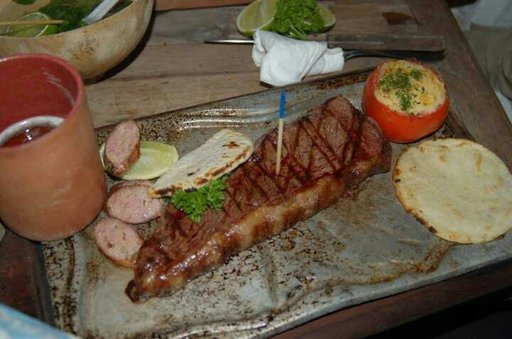

In [7]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))  # 1* is for trian and test / 2* is for pizza, steak and sushi and 3* is for any image file.


# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"Random image path: {random_image_path}")

# 3. Get the image class name
image_class = random_image_path.parent.stem   # parent is data/pizza_steak_sushi/train/sushi/ and stem is he end of that folder pizza
print(f"Image class: {image_class}")
print(f"Image class path: {random_image_path.parent}")

# 4. Open image : from the PIL but we can do this from Pytorch also like read
img = Image.open(random_image_path)

# 5. Print metadata
print(f"\nImage size: {img.size}")
print(f"\nImage mode: {img.mode}")
print(f"\nImage format: {img.format}")
print(f'\nImage height: {img.height}')
print(f'\nImage width: {img.width}')
print(f'\nImage info: {img.info}')
print(f"\n Image class: {image_class}")
img



(np.float64(-0.5), np.float64(511.5), np.float64(338.5), np.float64(-0.5))

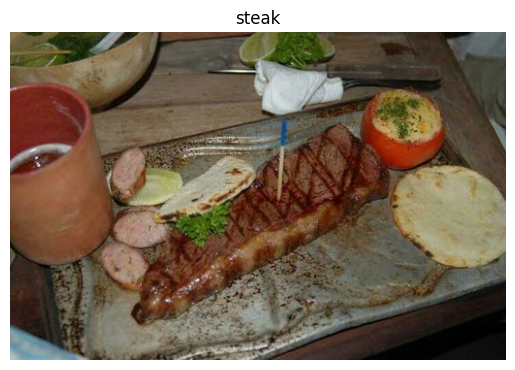

In [8]:
# Visualizing the data with matplotlib

import numpy as np  # to change the image into array
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(image_class)
plt.axis(False)



(np.float64(-0.5), np.float64(511.5), np.float64(338.5), np.float64(-0.5))

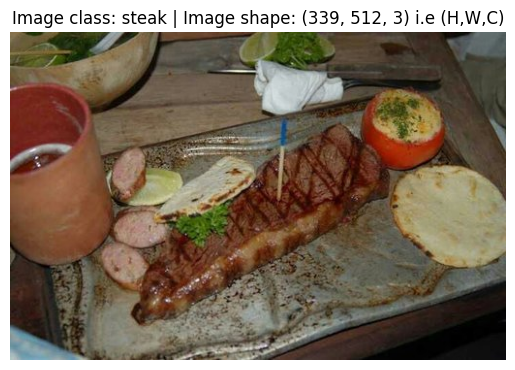

In [9]:
# Trun the image into an numpy array
img_as_array = np.asarray(img)
img_as_array.shape
plt.imshow(img)
plt.title(image_class)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} i.e (H,W,C)")
plt.axis(False)

## 3. Transforming data into tensor

1. Trun our target data into tensor (in this case; numerical representaation of our image)
2. Trun it into a `torch.utils.data.Dataset` and then `torch.utils.data.DataLoader` (i.e iterable or batched version of data set): **Dataset** and **DataLoader**


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

https://docs.pytorch.org/vision/0.21/transforms.html#:~:text=Transforms%20can%20be%20used%20to,%2C%20segmentation%2C%20video%20classification).&text=Transforms%20are%20typically%20passed%20as,transforms%20argument%20to%20the%20Datasets.

In [11]:
# transforming code

data_transform = transforms.Compose([       # we can also use `torch.nn.squential()`

    # Resize the image into 64 x 64.
    transforms.Resize(size=(64,64)),
    # Flip the images randomly wrt horizontal ( to increase the diversity i.e Data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into tensor.
    transforms.ToTensor()    # Convert a PIL Image or ndarray to tensor and scale the values accordingly.
                              #This transform does not support torchscript.
])



In [12]:
data_transform(img)

tensor([[[0.3451, 0.3804, 0.3843,  ..., 0.2392, 0.4235, 0.5137],
         [0.3255, 0.3686, 0.3765,  ..., 0.4000, 0.4196, 0.4706],
         [0.3294, 0.3529, 0.3765,  ..., 0.4000, 0.4196, 0.4314],
         ...,
         [0.0471, 0.0471, 0.0549,  ..., 0.5176, 0.4902, 0.4353],
         [0.0431, 0.0471, 0.0549,  ..., 0.4863, 0.4706, 0.5412],
         [0.0431, 0.0510, 0.0549,  ..., 0.4510, 0.4941, 0.6353]],

        [[0.3922, 0.4275, 0.4314,  ..., 0.2588, 0.3686, 0.4392],
         [0.3725, 0.4157, 0.4235,  ..., 0.3608, 0.3725, 0.4118],
         [0.3765, 0.3961, 0.4235,  ..., 0.3569, 0.3686, 0.3765],
         ...,
         [0.0471, 0.0471, 0.0549,  ..., 0.6353, 0.6235, 0.5843],
         [0.0431, 0.0471, 0.0549,  ..., 0.6275, 0.6078, 0.6471],
         [0.0431, 0.0510, 0.0549,  ..., 0.6275, 0.6392, 0.7176]],

        [[0.3922, 0.4275, 0.4314,  ..., 0.1020, 0.2275, 0.2980],
         [0.3725, 0.4157, 0.4235,  ..., 0.2157, 0.2392, 0.2902],
         [0.3725, 0.4000, 0.4235,  ..., 0.2039, 0.2314, 0.

Transformed image shape: torch.Size([64, 64, 3])
Transformed image shape: torch.Size([64, 64, 3])
Transformed image shape: torch.Size([64, 64, 3])


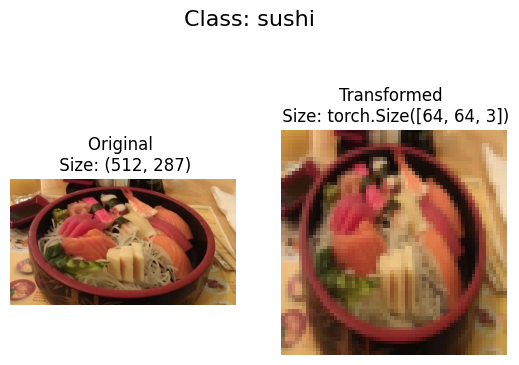

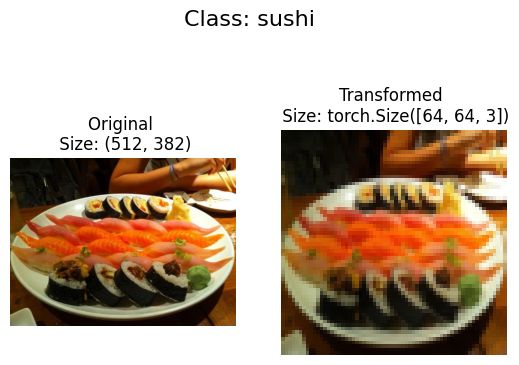

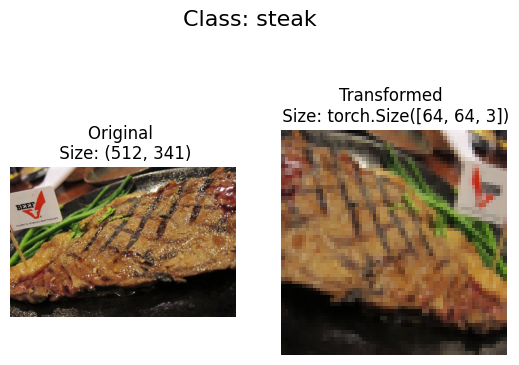

In [13]:
def plot_transform_images(image_paths, transform, n=3, seed= None):  #n=3 define the number of image to be transform at a time
  """
  select random images from a path of images and transform them.
  then plot the original images and the transformed images.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)  ## create the random selection of only 3 image as n=3
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis("off")

      # Transform and plot traget image
      transformed_image = data_transform(f).permute(1,2,0)  ## need to use permute function as matplot.lib only take image in HWC format
      print(f"Transformed image shape: {transformed_image.shape}")  # we can also use transform(f) only.Python looks up what transform refers to → finds it is a Compose object.
                                                                    # Compose has a __call__ method, making it behave like a function.
                                                                    # Thus, calling transform(f) applies all the transformations in order to the input f.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis(False)    # we can use "off" as above

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize= 16)

plot_transform_images(image_paths = image_path_list,
                      transform = data_transform,
                      n=3,
                      seed= 42)


## 4. Option 1: Loading image data using `Image folder`

We can load image classification data using `torchvision.datasets.ImageFolder`
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html


In [14]:
# Use Imagefolder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,    # a tranform for the data
                                  target_transform=None)  # a tranform for the label/traget

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data




(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [16]:
# Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class name as dict

class_dict= train_data.class_to_idx
class_dict   # they are used in traget_trasform in above function where do traanform for targeted lable only

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# check the length of our datset
len(train_data), len(test_data)

(225, 75)

In [19]:
# if we run to the some labled data we can check that data as:
train_data.samples[10]

('data/pizza_steak_sushi/train/pizza/1572608.jpg', 0)

In [20]:
# Index on the train_data Dataset to get a single image and label
train_data[10]

(tensor([[[0.8235, 0.8000, 0.7961,  ..., 0.8157, 0.8078, 0.8196],
          [0.7843, 0.7961, 0.8353,  ..., 0.8510, 0.8784, 0.8980],
          [0.8471, 0.8902, 0.9412,  ..., 0.9843, 0.9804, 0.9843],
          ...,
          [0.8039, 0.8549, 0.7882,  ..., 0.7882, 0.7529, 0.5412],
          [0.8078, 0.8196, 0.7922,  ..., 0.7176, 0.7608, 0.6784],
          [0.8471, 0.8824, 0.8784,  ..., 0.4902, 0.6627, 0.8196]],
 
         [[0.5882, 0.5686, 0.5647,  ..., 0.5882, 0.5725, 0.5882],
          [0.5333, 0.5569, 0.5961,  ..., 0.6824, 0.6980, 0.7098],
          [0.6039, 0.6549, 0.7059,  ..., 0.8706, 0.8667, 0.8627],
          ...,
          [0.5882, 0.6353, 0.5686,  ..., 0.4980, 0.4745, 0.3412],
          [0.6039, 0.6314, 0.6275,  ..., 0.4549, 0.4745, 0.4431],
          [0.6510, 0.7059, 0.7255,  ..., 0.2980, 0.4118, 0.5451]],
 
         [[0.2706, 0.2549, 0.2510,  ..., 0.3216, 0.3059, 0.3333],
          [0.2431, 0.2471, 0.2588,  ..., 0.4353, 0.4392, 0.4392],
          [0.2745, 0.2941, 0.3176,  ...,

In [21]:
img, label= train_data[10]
img

tensor([[[0.8235, 0.8000, 0.7961,  ..., 0.8157, 0.8078, 0.8196],
         [0.7843, 0.7961, 0.8353,  ..., 0.8510, 0.8784, 0.8980],
         [0.8471, 0.8902, 0.9412,  ..., 0.9843, 0.9804, 0.9843],
         ...,
         [0.8039, 0.8549, 0.7882,  ..., 0.7882, 0.7529, 0.5412],
         [0.8078, 0.8196, 0.7922,  ..., 0.7176, 0.7608, 0.6784],
         [0.8471, 0.8824, 0.8784,  ..., 0.4902, 0.6627, 0.8196]],

        [[0.5882, 0.5686, 0.5647,  ..., 0.5882, 0.5725, 0.5882],
         [0.5333, 0.5569, 0.5961,  ..., 0.6824, 0.6980, 0.7098],
         [0.6039, 0.6549, 0.7059,  ..., 0.8706, 0.8667, 0.8627],
         ...,
         [0.5882, 0.6353, 0.5686,  ..., 0.4980, 0.4745, 0.3412],
         [0.6039, 0.6314, 0.6275,  ..., 0.4549, 0.4745, 0.4431],
         [0.6510, 0.7059, 0.7255,  ..., 0.2980, 0.4118, 0.5451]],

        [[0.2706, 0.2549, 0.2510,  ..., 0.3216, 0.3059, 0.3333],
         [0.2431, 0.2471, 0.2588,  ..., 0.4353, 0.4392, 0.4392],
         [0.2745, 0.2941, 0.3176,  ..., 0.6000, 0.5882, 0.

In [22]:
label

0

In [23]:
class_names[label]

'pizza'

In [24]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label: {label}({class_names[label]})")
print(f"Label datatype: {type(label)}")

# Rearrange the order dimensions
img_permuted = img.permute(1,2,0)
print(f"\nImage shape: {img_permuted.shape}")
print(f"Image datatype: {img_permuted.dtype}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Label: 0(pizza)
Label datatype: <class 'int'>

Image shape: torch.Size([64, 64, 3])
Image datatype: torch.float32


## 4.1 Turn loaded data into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [25]:
# Turn train and test datsets into DataLoader's
from torch.utils.data import DataLoader

batch_size = 16
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b26e114a5d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b26e0f24b50>)

In [26]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [27]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label datatype: {label.dtype}")

Image shape: torch.Size([16, 3, 64, 64])
Image datatype: torch.float32
Label shape: torch.Size([16])
Label datatype: torch.int64


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Load image from the file
2. Get class names from the dataset
3. Get classes as dictionary from the datasets.

Pros:
* Can create a `Dataset` out of almost anything.
* Not limited to PyTorch pre-built `Dataset function`

Cons:
* It may not work or function correctly or malfunction.
* Often lead to tremendous coding and leading to error and performance issue.


All custom Datasets in PyTorch, often subclass:  https://docs.pytorch.org/docs/stable/data.html#module-torch.utils.data


In [28]:
import os
import pathlib
import torch

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from typing import List, Tuple, Dict


In [29]:
# Recreating torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a traget directory (the diretory is in standard image classification format)
2. Raise a error if the class name arenot found.
3. trun the class names into a dict and a list and return them.



In [30]:
# Setup path for target directory
traget_directory = train_dir
print(f"Target dir: {traget_directory}")

# Extracting class names
class_names = [entry.name for entry in os.scandir(traget_directory) if entry.is_dir()]
print(f"Class names: {class_names}")

Target dir: data/pizza_steak_sushi/train
Class names: ['sushi', 'steak', 'pizza']


In [31]:
def Class_and_idx(directory:str) -> Tuple[List[str], Dict[str, int]]:

  # 1. Get the class name by scanning the traget directory.
  class_names = sorted(entry.name for entry in os.scandir(traget_directory) if entry.is_dir())

  # 2. Raise an error if class names could not found

  if not class_names:
    raise FileNotFoundError(f"Couldn't find any class name in {traget_directory}.")

  # 3. Creating the dictionary
  class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

  return class_names, class_to_idx


In [32]:
Class_and_idx(traget_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset`

To create our own custom `Dataset` we need to subclass:

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory also transform (optional)
3. Create several Attributes:
    * paths - paths of our images
    * transform - different transform accordingly
    * classes - a list of the traget classes
    * class_to_idx- a dict
4. Create a function to `load_images()`, function to open image
5. Overwrite the`__len__()` method.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

`classtorch.utils.data.Dataset`

An abstract class representing a Dataset.

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite `__getitem__()`, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite `__len__()`, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement `__getitems__()`, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.

In [33]:
# Write a custom dataset class

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class CustomDataset(Dataset):
  # 2. Inintialize our custom dataset
    def __init__(self,
                 target_dir: str,
                 transform=None):
        # 3. create class attributes
        # get all of image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # setup transform
        self.transform = transform
        # setup class names
        self.classes, self.class_to_idx = Class_and_idx(target_dir)   # created above

  # 4. Function to load image
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
  # 5. Overwrite the __len__()
    def __len__(self):
      return len(self.paths)

  # 6. Overwrite the __getitem__() method to return a sample
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
      """ returns one sample of data i.e data and label"""
      img=self.load_image(index)
      class_name = self.paths[index].parent.name  # path in format: data_folder/class_name/image.jpg
      class_idx = self.class_to_idx[class_name]

    # If transform exist
      if self.transform:
        return self.transform(img), class_idx

      else:
        return img, class_idx # return the untransformed dataa


In [37]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])